# Livneh Wrfcf Bias 2017-02-05 to 2017-02-17 Over California Oregon Washington Region

In [1]:
# imports
import numpy
import Nio
import Ngl
from IPython import display
import netCDF4 as nc
from datetime import date
from datetime import timedelta
import xarray as xr
import xesmf as xe
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import geopandas as gpd
import earthpy as et
import regionmask

In [2]:
# read in daily difference datasets
dif_05 = xr.open_dataarray('./dif_05-Copy1.nc')
dif_06 = xr.open_dataarray('./dif_06-Copy1.nc')
dif_07 = xr.open_dataarray('./dif_07-Copy1.nc')
dif_08 = xr.open_dataarray('./dif_08-Copy1.nc')
dif_09 = xr.open_dataarray('./dif_09-Copy1.nc')
dif_10 = xr.open_dataarray('./dif_10-Copy1.nc')
dif_11 = xr.open_dataarray('./dif_11-Copy1.nc')
dif_12 = xr.open_dataarray('./dif_12-Copy1.nc')
dif_13 = xr.open_dataarray('./dif_13-Copy1.nc')
dif_14 = xr.open_dataarray('./dif_14-Copy1.nc')
dif_15 = xr.open_dataarray('./dif_15-Copy1.nc')

# define dictionary
dif_dict = {5:dif_05, 6:dif_06, 7:dif_07, 8:dif_08, 9:dif_09, 
            10:dif_10, 11:dif_11, 12:dif_12, 13:dif_13, 14:dif_14, 
            15:dif_15}

In [3]:
# average the difference over the 13 days, returns DataArray object
def bias_arr():
    next_key = 6
    temp = dif_dict[5]
    while next_key <= 15:
        arr1 = temp
        arr2 = dif_dict[next_key]
        next_key += 1
        temp = numpy.add(arr1, arr2)
    bias = temp / 11
    return bias

bias_out = bias_arr()
bias_out

<xarray.DataArray (lat: 444, lon: 922)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 25.16 25.22 25.28 25.34 ... 52.66 52.72 52.78 52.84
  * lon      (lon) float64 -124.6 -124.5 -124.5 -124.4 ... -67.16 -67.09 -67.03

In [4]:
# save as a nc file for later
bias_out.to_netcdf('./bias_ca_17.nc')

In [5]:
# convert dif_arr to masked array to overlook NaNs
import numpy.ma as ma
m_out = ma.masked_invalid(bias_out.data)
m_out

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20)

In [6]:
# create dataarray structure
lat_coord = bias_out['lat'].data.flatten()
lon_coord = bias_out['lon'].data.flatten()
d_arr = xr.DataArray(m_out, coords = [lat_coord, lon_coord], dims = ['lat', 'lon'])
d_arr

<xarray.DataArray (lat: 444, lon: 922)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 25.16 25.22 25.28 25.34 ... 52.66 52.72 52.78 52.84
  * lon      (lon) float64 -124.6 -124.5 -124.5 -124.4 ... -67.16 -67.09 -67.03

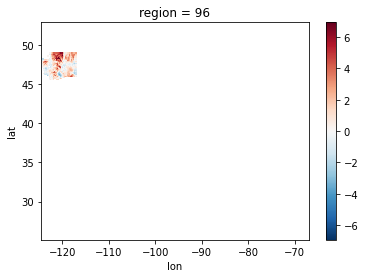

In [7]:
# masking california

# reading in livneh for universal mask
fn = '/cw3e/mead/projects/cwp103/scratch/ldehaan/Livneh/ptt_2017.nc'
liv = xr.open_dataset(fn)
liv_tm = liv['Tmax'][36:47]

# Download natural earth data which contains state boundaries to generate AOI
states_path = "ne_50m_admin_1_states_provinces_lakes-Copy1.shp"
states_gdf = gpd.read_file(states_path)

# You will use the bounds to determine the slice values for this data
# Select any state in the CONUS that you wish here! California is the default
cali_aoi = states_gdf[states_gdf.name == "California"]
or_aoi = states_gdf[states_gdf.name == "Oregon"]
wa_aoi = states_gdf[states_gdf.name == "Washington"]

# Create a 3d mask - this contains the true / false values identifying pixels
# inside vs outside of the mask region
cali_mask = regionmask.mask_3D_geopandas(cali_aoi,liv.lon,liv.lat)
or_mask = regionmask.mask_3D_geopandas(or_aoi, liv.lon, liv.lat)
wa_mask = regionmask.mask_3D_geopandas(wa_aoi, liv.lon, liv.lat)

# Apply the mask for California to the data, apply different masks (not all at once)
da_ca = d_arr.where(wa_mask)

# plotting masking for reference
da_ca.plot()
plt.show()

In [8]:
# convert to masked array to overlook NaNs
m_out = ma.masked_invalid(da_ca)
m_out

masked_array(
  data=[[[--],
         [--],
         [--],
         ...,
         [--],
         [--],
         [--]],

        [[--],
         [--],
         [--],
         ...,
         [--],
         [--],
         [--]],

        [[--],
         [--],
         [--],
         ...,
         [--],
         [--],
         [--]],

        ...,

        [[--],
         [--],
         [--],
         ...,
         [--],
         [--],
         [--]],

        [[--],
         [--],
         [--],
         ...,
         [--],
         [--],
         [--]],

        [[--],
         [--],
         [--],
         ...,
         [--],
         [--],
         [--]]],
  mask=[[[ True],
         [ True],
         [ True],
         ...,
         [ True],
         [ True],
         [ True]],

        [[ True],
         [ True],
         [ True],
         ...,
         [ True],
         [ True],
         [ True]],

        [[ True],
         [ True],
         [ True],
         ...,
         [ True],
  

In [10]:
# numerical data, average across CA region
numpy.mean(m_out)
# CA: -1.1372981856100004
# OR: -0.40271883936642594
# WA: 1.2137380200207832
numpy.mean([-1.1372981856100004,-0.40271883936642594,1.2137380200207832])

-0.10875966831854773